# Eta X V1 Example
## Pool Collection
The following is an example in which our smart order router is used to identify optimal routes for selling USDC for WETH. A user inputs the token they want to buy, the token they want to sell, and the amount they want to sell. Pools are then queried for permutations of those tokens and sorted by their reserves. In this example, we are loading pools from a JSON file which were previously retrieved via the pool collector for simplicity's sake.

In [11]:
import json
with open('src/data/USDC-WETH.json') as f:
    pools = json.load(f)

In [19]:
from src.graph_constructor import construct_pool_graph, draw_pool_graph, pool_graph_to_dict
from src.pathfinder import find_shortest_paths, validate_all_paths, create_path_graph, draw_path_graph, path_graph_to_dict
from src.path_crawler import calculate_routes

## Creating a Graph of Pools
The pools are then used to generate a graph of possible swap routes, if two pools share an asset, they are connected (this includes pools which contain both assets, which loop on themselves).

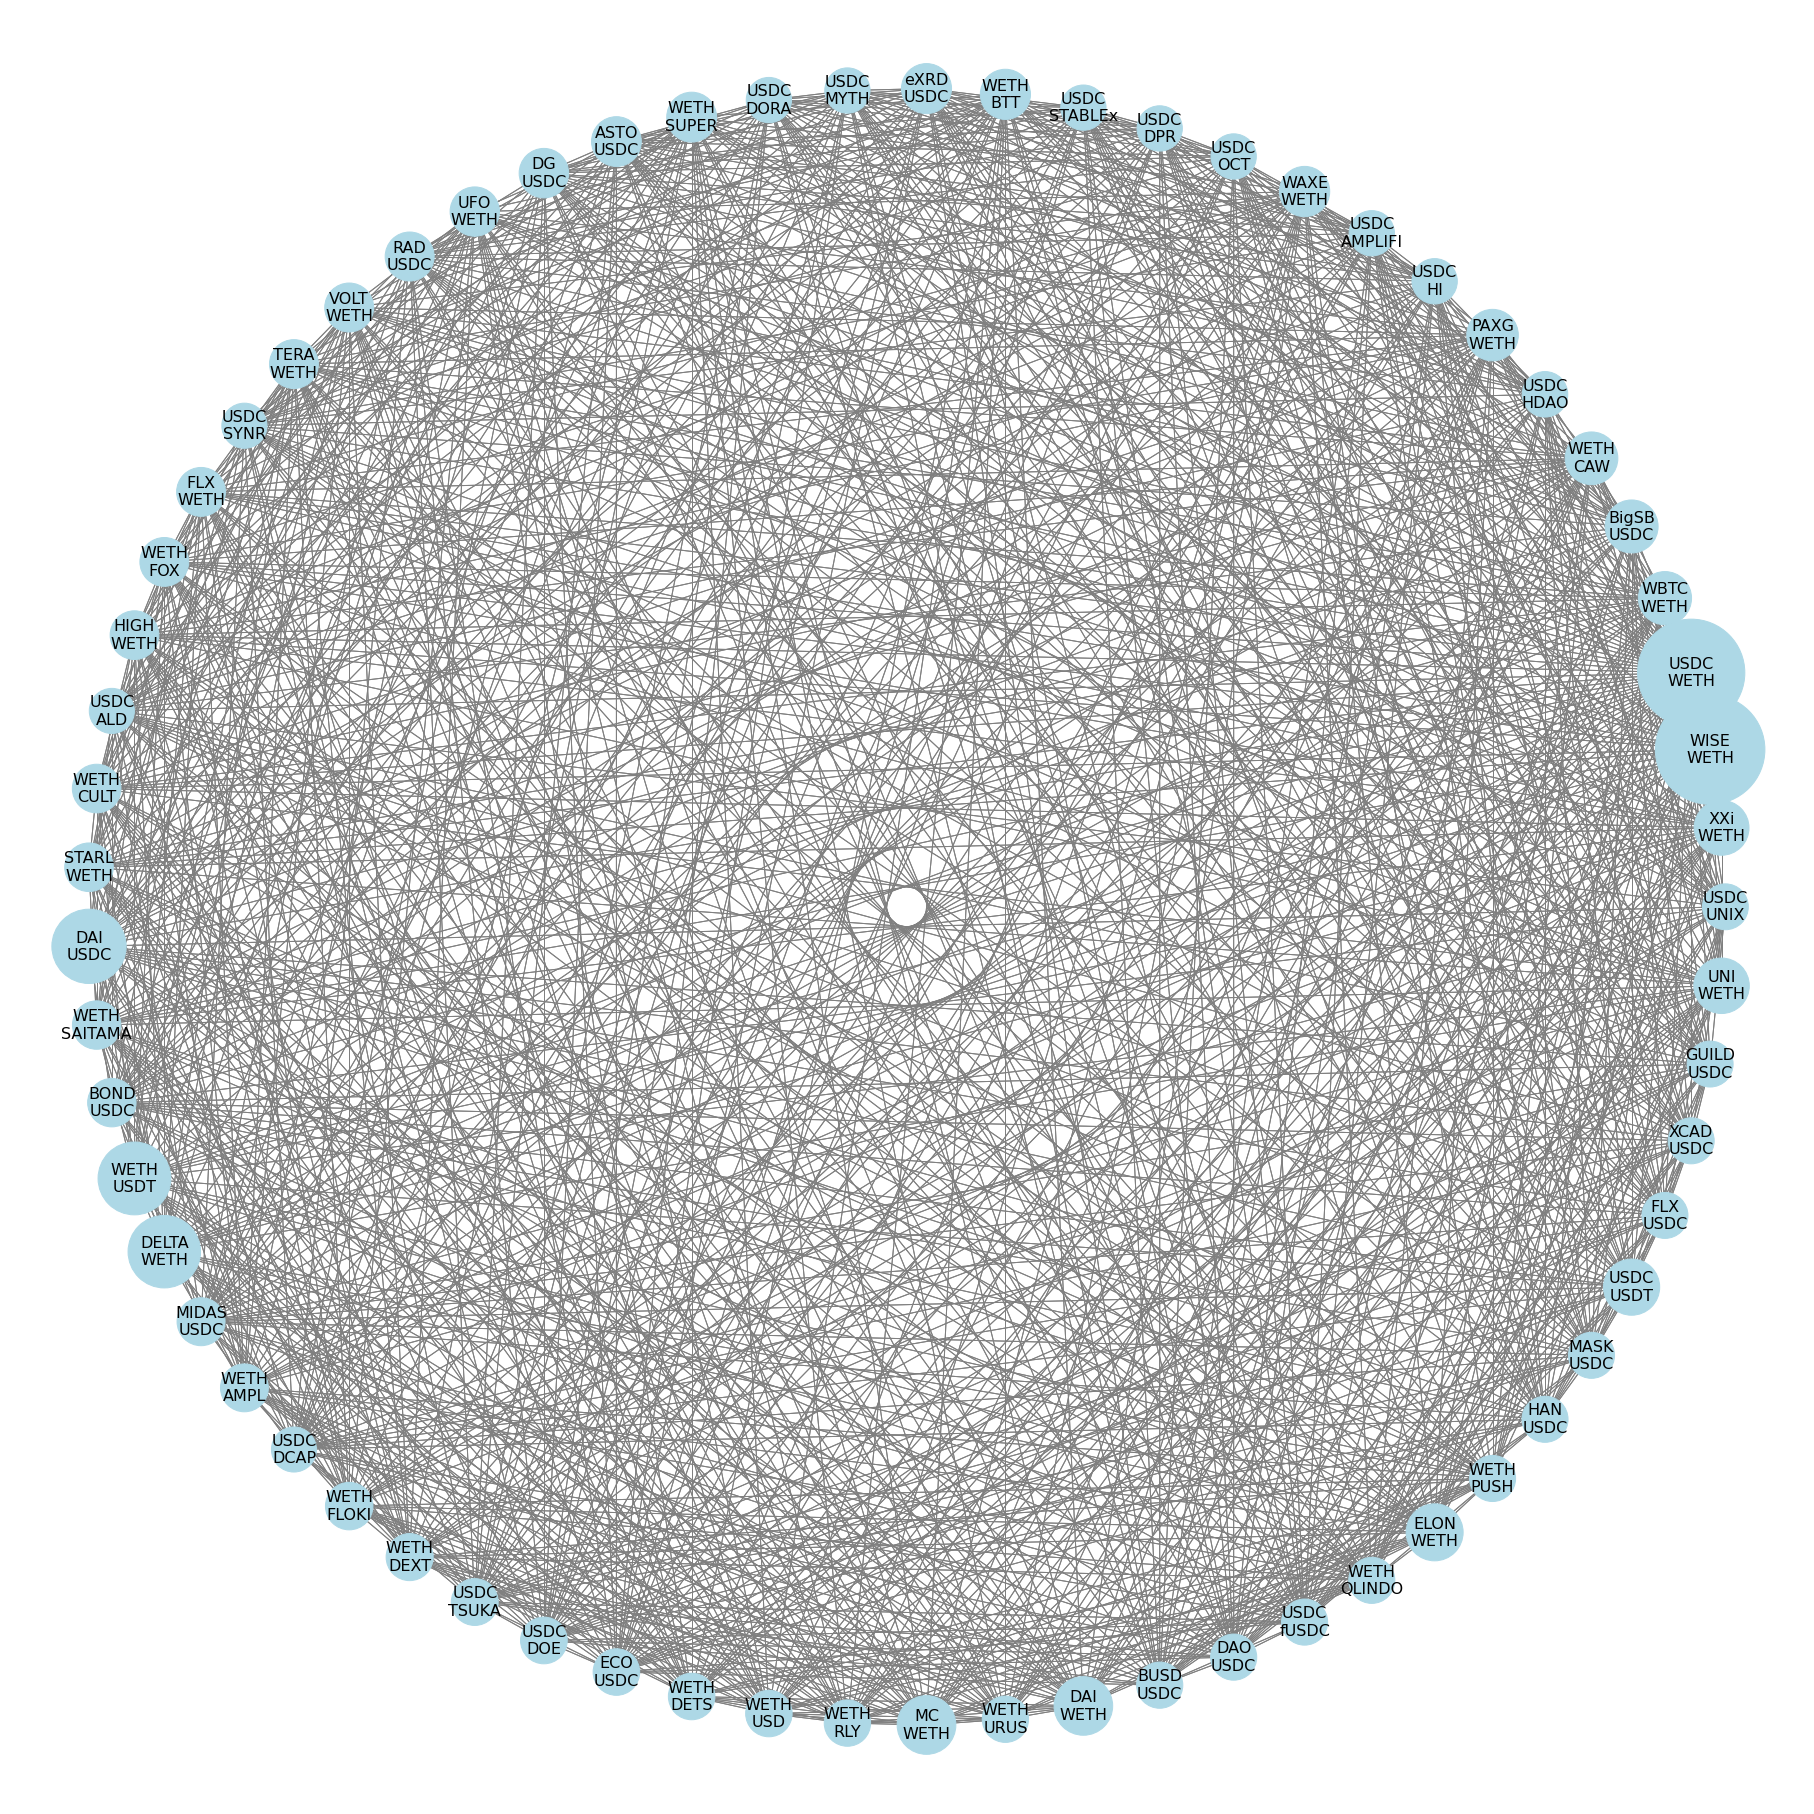

In [14]:
G = construct_pool_graph(pools)
draw_pool_graph(G)

## Finding Paths Between Pools
The concept of traversing pools can be thought of as selling token A for token B in pool 1, then taking the token B you received to pool 2 and using it to buy token C. The Bellman-Ford algorithm is used to identify the shortest paths from pools containing the sell token to pools containing the buy token. However, further augmentation is required to determine which of these paths are actually possible. For example, if we are selling USDC for WETH, the path:

['DAI_USDC_0xae461ca67b15dc8dc81ce7615e0320da1a9ab8d5',
'USDC_WETH_0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc']

is not actually a valid route, as we are selling USDC for DAI in the first pool, and DAI is not accepted by the second pool. Some examples of valid paths are shown in the code outputs below.

In [15]:
paths = find_shortest_paths(G, 'USDC', 'WETH')
valid_paths = validate_all_paths(G, paths, 'USDC', 'WETH')
valid_paths

[['USDC_WETH_0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc'],
 ['DAI_USDC_0xae461ca67b15dc8dc81ce7615e0320da1a9ab8d5',
  'DAI_WETH_0xa478c2975ab1ea89e8196811f51a7b7ade33eb11'],
 ['USDC_USDT_0x3041cbd36888becc7bbcbc0045e3b1f144466f5f',
  'WETH_USDT_0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852']]

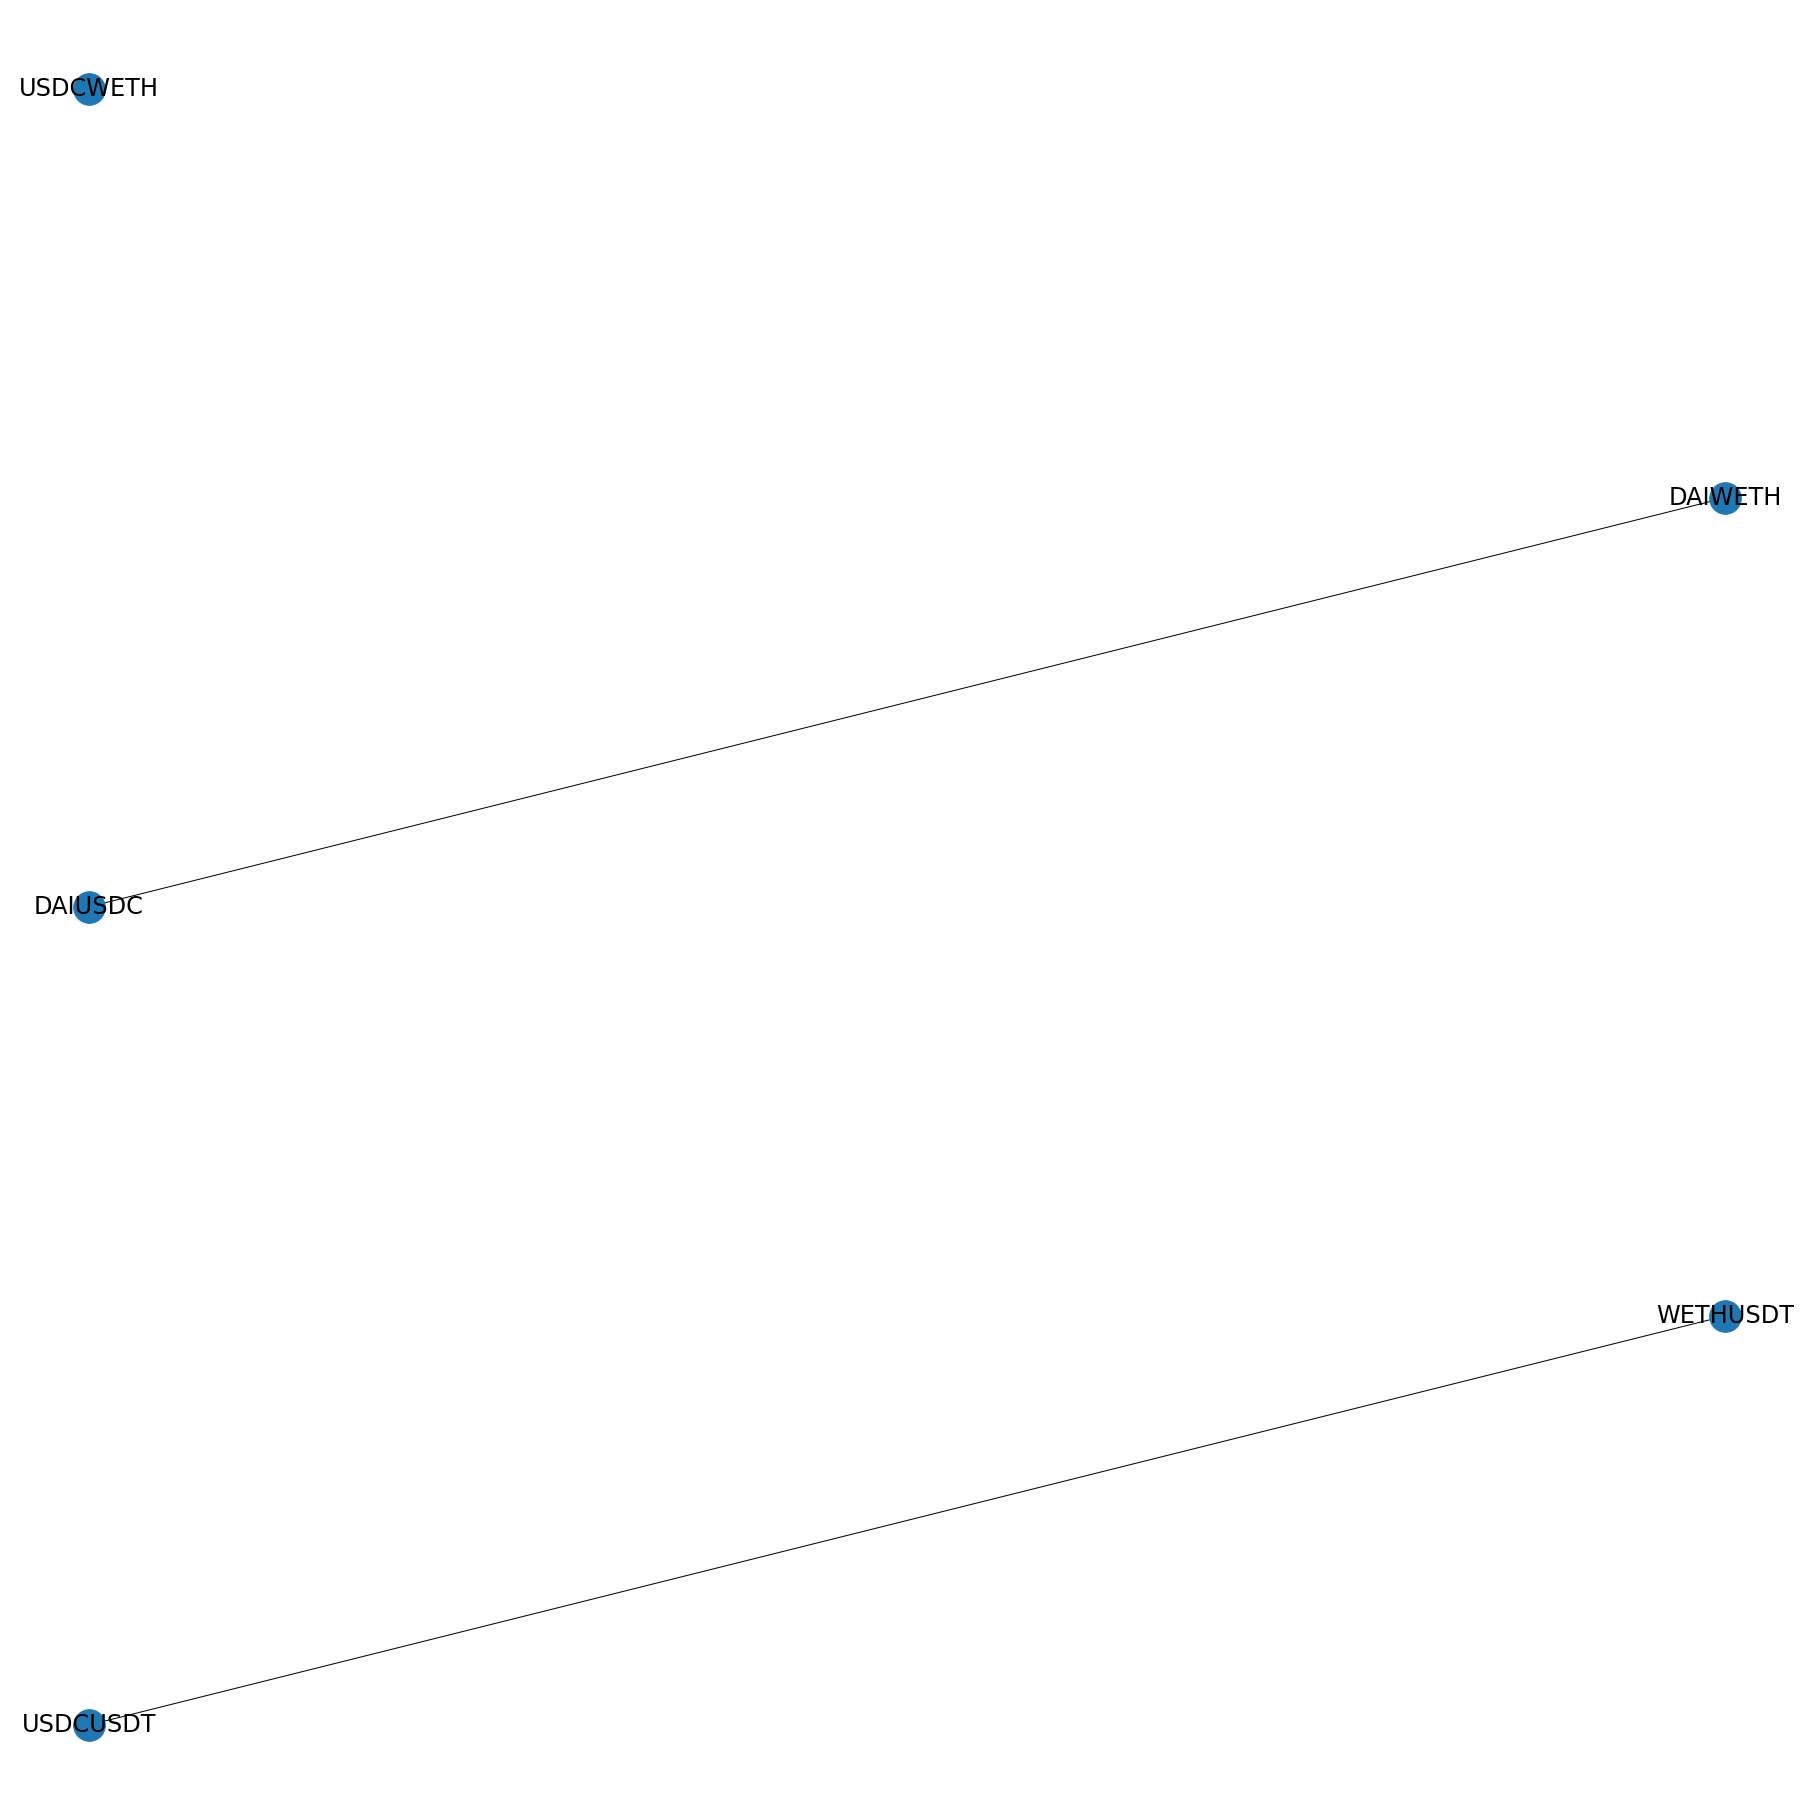

In [16]:
G_paths = create_path_graph(valid_paths)
draw_path_graph(G_paths)

## Crawling Over Paths With XYK
Once valid paths have been identified, we then traverse each of those paths and call the XYK price impact calculator at each swap, giving us an actual return, price impact, and description of the swap.

In [17]:
routes = calculate_routes(G, valid_paths, 500_000, 'USDC', 'WETH')

path 0
swap 0
Sell 500000 USDC for WETH in Uniswap V2 0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc
    
Expected payout: 377.6276842609607 WETH
    
Actual payout: 373.4322311092765 WETH
    
Price impact: 1.1110025367697673%
    
------------------------------------------------------------
path 1
swap 0
Sell 500000 USDC for DAI in Uniswap V2 0xae461ca67b15dc8dc81ce7615e0320da1a9ab8d5
    
Expected payout: 499892.01725975383 DAI
    
Actual payout: 485164.9498644918 DAI
    
Price impact: 2.946049724096622%
    
swap 1
Sell 485164.9498644918 DAI for WETH in Uniswap V2 0xa478c2975ab1ea89e8196811f51a7b7ade33eb11
    
Expected payout: 367.0493801215431 WETH
    
Actual payout: 342.2887761266211 WETH
    
Price impact: 6.745850922489749%
    
------------------------------------------------------------
path 2
swap 0
Sell 500000 USDC for USDT in Uniswap V2 0x3041cbd36888becc7bbcbc0045e3b1f144466f5f
    
Expected payout: 499749.12144452956 USDT
    
Actual payout: 457474.1902111983 USDT
    
P

# API Result Examples
API requests will return the following format:

`{
    "path_graph": {"NODE": ["NODE",..., "NODE"]},
    "pool_graph": {"NODE": ["NODE",..., "NODE"]}
    "routes": {
        {'route_X': {
            'swap_X': {'pool': 'POOL',
        'input_token': 'SYMBOL',
        'output_token': 'SYMBOL',
        'output_amount': float,
        'price_impact': float,
        'price': float,
        'gas_fee': float,
        'description': 'SWAP_DESCRIPTION'},
        'amount_in': float,
        'amount_out': float,
        'price': float,
        'gas_fee': float,
        'path': ["NODE",..., "NODE"]}
        }
`}

In [22]:
path_graph_to_dict(G_paths)

{'USDC_WETH_0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc': [],
 'DAI_USDC_0xae461ca67b15dc8dc81ce7615e0320da1a9ab8d5': ['DAI_WETH_0xa478c2975ab1ea89e8196811f51a7b7ade33eb11'],
 'DAI_WETH_0xa478c2975ab1ea89e8196811f51a7b7ade33eb11': ['DAI_USDC_0xae461ca67b15dc8dc81ce7615e0320da1a9ab8d5'],
 'USDC_USDT_0x3041cbd36888becc7bbcbc0045e3b1f144466f5f': ['WETH_USDT_0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852'],
 'WETH_USDT_0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852': ['USDC_USDT_0x3041cbd36888becc7bbcbc0045e3b1f144466f5f']}

In [26]:
routes

{'route_0': {'swap_0': {'pool': 'USDC_WETH_0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc',
   'input_token': 'USDC',
   'output_token': 'WETH',
   'output_amount': 373.4322311092765,
   'price_impact': 1.1110025367697673,
   'price': 1338.9310250878864,
   'gas_fee': 0.000274314535047,
   'description': 'Sell 500000 USDC for WETH in Uniswap V2 0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc\n    \nExpected payout: 377.6276842609607 WETH\n    \nActual payout: 373.4322311092765 WETH\n    \nPrice impact: 1.1110025367697673%\n    '},
  'amount_in': 500000,
  'amount_out': 373.4322311092765,
  'price': 1338.9310250878864,
  'gas_fee': 0.000274314535047,
  'path': ['USDC_WETH_0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc']},
 'route_1': {'swap_0': {'pool': 'DAI_USDC_0xae461ca67b15dc8dc81ce7615e0320da1a9ab8d5',
   'input_token': 'USDC',
   'output_token': 'DAI',
   'output_amount': 485164.9498644918,
   'price_impact': 2.946049724096622,
   'price': 1.0305773328012497,
   'gas_fee': 0.000274314535047,
 

In [20]:
pool_graph_to_dict(G)

{'USDC_UNIX_0xccab68f48531215b0707e8d908c43e7de73dbdbc': ['USDC_UNIX_0xccab68f48531215b0707e8d908c43e7de73dbdbc',
  'USDC_WETH_0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc',
  'BigSB_USDC_0x149148acc3b06b8cc73af3a10e84189243a35925',
  'USDC_HDAO_0xa577979fcb7306b70fcc9c7c57cb5b750cbed769',
  'USDC_HI_0xe416501e8dae5ca238e708acefb9cc2583f2dbb6',
  'USDC_AMPLIFI_0xdf527342aaedfc0683f4c75ad791a51e8aafaf4a',
  'USDC_OCT_0x8672aa02f8a5b6eb6bb0915ce6c65f771d705127',
  'USDC_DPR_0x85673c92f0f27a9c4d8c221f6bfefa33b716338a',
  'USDC_STABLEx_0x1bcce9e2fd56e8311508764519d28e6ec22d4a47',
  'eXRD_USDC_0x684b00a5773679f88598a19976fbeb25a68e9a5f',
  'USDC_MYTH_0x4620bee6e5bd679b0242bf0bd6291b0ac45b909b',
  'USDC_DORA_0x82cd7e4b567ad7d2a00c3cc93ac968ccb61cafca',
  'ASTO_USDC_0x11181bd3baf5ce2a478e98361985d42625de35d1',
  'DG_USDC_0x873056a02255872514f05249d93228d788fe4fb4',
  'RAD_USDC_0x8c1c499b1796d7f3c2521ac37186b52de024e58c',
  'USDC_SYNR_0xd14782a6f2512495584a252ffca49b17486a08d3',
  'USDC_ALD_0xaa